# Chargement des données


In [122]:
!git clone https://github.com/Romain-Malinge/Deep_learning_groupe_A.git
path = "./Deep_learning_groupe_A/BD/"

fatal: destination path 'Deep_learning_groupe_A' already exists and is not an empty directory.


Une fois les données téléchargées localement, on peut maintenant charger les images et les labels. Si vous avez construit votre arborescence de la même manière que la mienne, et que vous adaptez les noms de labels à votre projet, alors le code suivant devrait être utilisable directement.

In [123]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat


def load_data(data_path, classes, dataset, row, col):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)

    x = np.zeros((num_images, row, col, 3))
    y = np.zeros((num_images, 4))

    current_index = 0

    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)

        # Chargement des images,
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Redimensionnement de l'image et écriture dans la variable de retour x
                img = img.resize((col, row))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index,idx_class] = 1
                current_index += 1

    return x, y

Voici ensuite un exemple de chargement de vos données. Notez que vous pouvez modifier la dimension des images, ce qui sera utile à différents stades de votre projet.

In [124]:
row = 192 // 2
col = 256 // 2

labels = ["1","2","3","4"]

x_train, y_train = load_data(path, labels, 'entrainement', row, col)
print(x_train.shape, y_train.shape)

x_val, y_val = load_data(path, labels, 'validation', row, col)
print(x_val.shape, y_val.shape)

x_test, y_test = load_data(path, labels, 'test', row, col)
print(x_test.shape, y_test.shape)

(4000, 96, 128, 3) (4000, 4)
(1000, 96, 128, 3) (1000, 4)
(100, 96, 128, 3) (100, 4)


Vous pouvez utiliser le bloc suivant pour afficher quelques-unes de vos images, et ainsi vérifier que tout s'est bien passé.

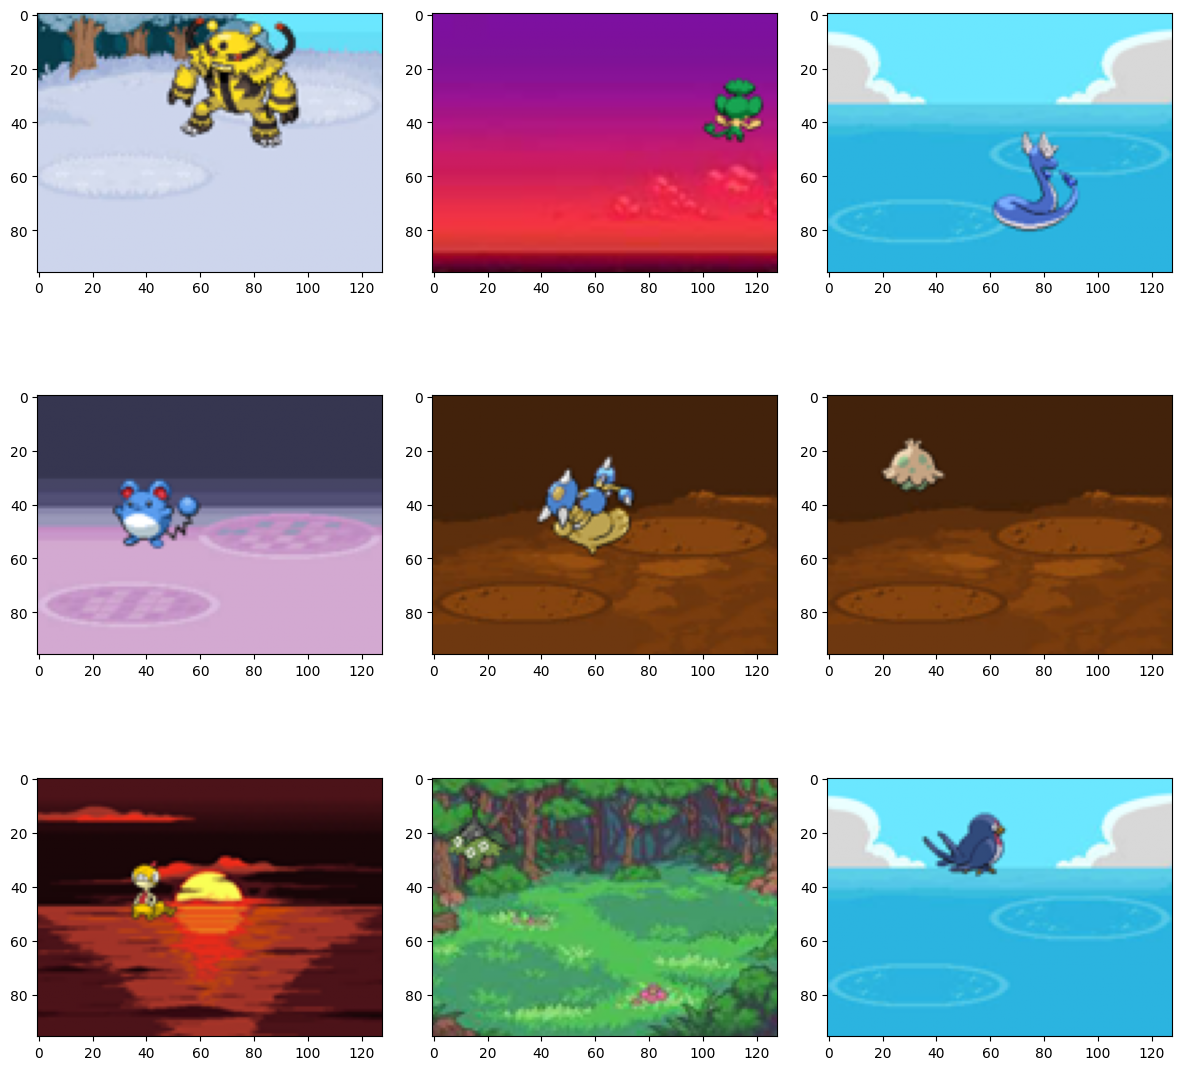

In [125]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
shuffle_indices = np.random.permutation(9)
for i in range(0, 9):
    plt.subplot(3, 3, i+1)
    image = x_train[shuffle_indices[i]]
    # plt.title(labels[int(y_train[shuffle_indices[i]])])
    plt.imshow(image/255)

plt.tight_layout()
plt.show()

#  Création de notre réseau de neurones

Dans un premier temps nous allons utiliser un réseau basique et voir les résultats.

In [126]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
import glob
import PIL
from PIL import Image
import numpy as np
from tensorflow.keras import optimizers
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from keras import regularizers

model = Sequential()
# 1er couche
model.add(Conv2D(32, (3,3), input_shape = [row, col,3], activation='relu'))
model.add(MaxPooling2D(2,2))
# 2nd couche
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
# 3eme couche
model.add(Conv2D(96, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
# 4eme couche
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())    # "Mise à plat" (vectorisation) du tenseur pour permettre de la connecter à une couche dense


model.add(Dense(512, activation='relu')) # input_dim indique la dimension de la couche d'entrée, ici 512
model.add(Dense(100, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 94, 126, 32)       896       
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 47, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 45, 61, 64)        18496     
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 22, 30, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 20, 28, 96)        55392     
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 10, 14, 96)      

In [127]:
# Fonction cout
model.compile(loss="binary_crossentropy",
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['accuracy'])

In [128]:
# On prend les meilleurs valeurs
checkpoint_filepath = path +"/bestPoint"
model_checkpoint_callback = ModelCheckpoint(
    filepath= checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [129]:
# Analyse de notre modèle
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=20, batch_size=10, validation_split = 0.2, callbacks=[model_checkpoint_callback])
model.load_weights(checkpoint_filepath)

Epoch 1/20
400/400 [==============================] - 7s 13ms/step - loss: 0.6333 - accuracy: 0.3590 - val_loss: 0.4887 - val_accuracy: 0.4380
Epoch 2/20
400/400 [==============================] - 4s 9ms/step - loss: 0.4609 - accuracy: 0.5010 - val_loss: 0.4564 - val_accuracy: 0.4760
Epoch 3/20
400/400 [==============================] - 4s 9ms/step - loss: 0.4033 - accuracy: 0.5835 - val_loss: 0.4813 - val_accuracy: 0.4950
Epoch 4/20
400/400 [==============================] - 4s 11ms/step - loss: 0.3545 - accuracy: 0.6615 - val_loss: 0.4024 - val_accuracy: 0.5910
Epoch 5/20
400/400 [==============================] - 4s 11ms/step - loss: 0.3041 - accuracy: 0.7310 - val_loss: 0.3711 - val_accuracy: 0.6180
Epoch 6/20
400/400 [==============================] - 3s 7ms/step - loss: 0.2581 - accuracy: 0.7865 - val_loss: 0.4010 - val_accuracy: 0.6080
Epoch 7/20
400/400 [==============================] - 3s 7ms/step - loss: 0.2011 - accuracy: 0.8382 - val_loss: 0.4569 - val_accuracy: 0.6030
Epo

In [130]:
def plot_training_analysis():
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

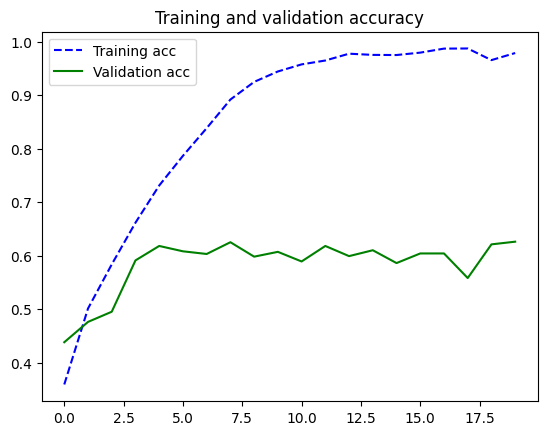

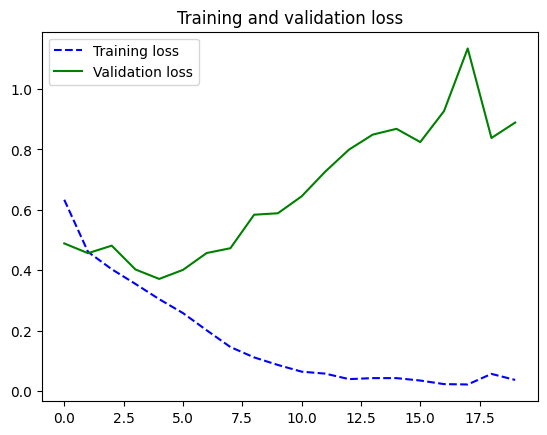

In [131]:
# Affichage du training
plot_training_analysis()

Pour les données de test, il faudra utiliser un evaluate.
Le code suivant ne fonctionne pas.


In [132]:
# Résultat avec les tests
result = model.evaluate(x_test, y_test, batch_size=10)

10/10 [==============================] - 0s 4ms/step - loss: 4.4964 - accuracy: 0.2900


Les prochaines étapes pour éviter le surapprentissage


*   Générer plus de données
*   Ajouter du texte (boîtes de dialogue) et/ou des carrés pour polluer l'image
*   Charger les images par patch

